In [168]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.metrics import mean_squared_error

In [169]:
path = "/Users/aayush/Desktop/POP/"
file = "train.csv"
fullpath = os.path.join(path,file)
data = open(fullpath,'r+')
cols=data.__next__().strip().split(',')
no_cols = len(cols)

In [170]:
counter = 0
main_dict = {}
for col in cols:
    main_dict[col] = []
    
for line in data:
    values = line.strip().split(',')
    for i in range(len(cols)):
        main_dict[cols[i]].append(values[i])
    counter += 1
    
"The dataset has %d rows and %d coloumns" % (counter,no_cols)

'The dataset has 2172 rows and 2 coloumns'

In [171]:
df = pd.DataFrame(main_dict)
df

,"""Month""","""Zuerich"""
0,"""1749-01""",58.0
1,"""1749-02""",62.6
2,"""1749-03""",70.0
3,"""1749-04""",55.7
4,"""1749-05""",85.0
5,"""1749-06""",83.5
6,"""1749-07""",94.8
7,"""1749-08""",66.3
8,"""1749-09""",75.9
9,"""1749-10""",75.5


In [172]:
# date-time parsing function for loading the dataset

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [173]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame({'Zuerich' : df['"Zuerich"'].tolist() })
data = data.values
data =data.astype('float32')
data

array([[  58.        ],
       [  62.59999847],
       [  70.        ],
       ..., 
       [  54.        ],
       [  81.09999847],
       [ 108.        ]], dtype=float32)

In [174]:
data = scaler.fit_transform(data)
data

array([[ 0.24277942],
       [ 0.26203433],
       [ 0.29300964],
       ..., 
       [ 0.22603601],
       [ 0.33947259],
       [ 0.45207202]], dtype=float32)

In [175]:
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

In [176]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX

array([[ 0.24277942],
       [ 0.26203433],
       [ 0.29300964],
       ..., 
       [ 0.32398495],
       [ 0.43658438],
       [ 0.32356638]], dtype=float32)

In [177]:
trainX = trainX.tolist()
c = []
for i in range(0,len(trainX)):
    c.append(trainX[i][0])
trainX = c

In [178]:
trainY.tolist()

[0.2620343267917633,
 0.2930096387863159,
 0.23315197229385376,
 0.3557974398136139,
 0.34951865673065186,
 0.39681878685951233,
 0.2775219976902008,
 0.3177061975002289,
 0.3160318434238434,
 0.6638761758804321,
 0.35663458704948425,
 0.3068229854106903,
 0.3177061975002289,
 0.3733780086040497,
 0.3696107566356659,
 0.3767266869544983,
 0.4185852110385895,
 0.357471764087677,
 0.43114277720451355,
 0.38174968957901,
 0.27501046657562256,
 0.26496443152427673,
 0.3156132698059082,
 0.2930096387863159,
 0.1820845603942871,
 0.18961909413337708,
 0.236082062125206,
 0.25408121943473816,
 0.21222271025180817,
 0.2775219976902008,
 0.25031396746635437,
 0.09836752712726593,
 0.0971117690205574,
 0.11929678916931152,
 0.1841774880886078,
 0.14650481939315796,
 0.20929260551929474,
 0.2971954941749573,
 0.2482210248708725,
 0.249895378947258,
 0.16575974225997925,
 0.3281708061695099,
 0.12264546751976013,
 0.11343659460544586,
 0.19506070017814636,
 0.15738803148269653,
 0.1674340814352035

In [179]:
testX = testX.tolist()
c = []
for i in range(0,len(testX)):
    c.append(testX[i][0])
testX = c

In [180]:
testY.tolist()

[0.7367099523544312,
 0.5676015615463257,
 0.5542067885398865,
 0.6437840461730957,
 0.5692759156227112,
 0.6128087043762207,
 0.6174131631851196,
 0.544160783290863,
 0.3696107566356659,
 0.5244872570037842,
 0.5994139909744263,
 0.6797823309898376,
 0.6090415120124817,
 0.3838426172733307,
 0.43114277720451355,
 0.46044373512268066,
 0.3361239433288574,
 0.37254083156585693,
 0.4411888122558594,
 0.3779824674129486,
 0.3327752351760864,
 0.502720832824707,
 0.3700293302536011,
 0.4273754954338074,
 0.45039767026901245,
 0.4600251615047455,
 0.44160738587379456,
 0.3888656795024872,
 0.47969865798950195,
 0.43323570489883423,
 0.4688154458999634,
 0.35119301080703735,
 0.3629133701324463,
 0.4478861689567566,
 0.4114692807197571,
 0.3189619183540344,
 0.20050232112407684,
 0.1875261664390564,
 0.28003349900245667,
 0.28547510504722595,
 0.19882798194885254,
 0.19840939342975616,
 0.23189622163772583,
 0.20594392716884613,
 0.25449979305267334,
 0.2687316834926605,
 0.1942235380411148,

In [181]:
X = pd.DataFrame({'trainX' : trainX})
Y = pd.DataFrame({'trainY': trainY.tolist()})
Y = Y['trainY']
rf = RandomForestRegressor(n_jobs=2,oob_score=True,n_estimators=50)
rf.fit(X,Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=2, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [182]:
rf.oob_prediction_

array([ 0.29127862,  0.22222224,  0.26478594, ...,  0.27410991,
        0.46271107,  0.29568976])

In [183]:
rf.oob_score_

0.76798542328926245

In [184]:
testXIn = pd.DataFrame({'testX' : testX})
testPredict = rf.predict(testXIn)

In [185]:
# testPredict

In [186]:
trainXIn = pd.DataFrame({'trainX' : trainX})
trainPredict = rf.predict(trainXIn)

In [187]:
trainPredict

array([ 0.27257766,  0.25241505,  0.26341147, ...,  0.3150899 ,
        0.359744  ,  0.35155535])

In [188]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

/Applications/anaconda/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Applications/anaconda/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [189]:
trainY

array([[  62.59999606,   69.99999755,   55.70000208, ...,  104.30000148,
          77.30000181,  114.89999977]])

In [190]:
testY

array([[  1.75999995e+02,   1.35600003e+02,   1.32399992e+02,
          1.53799997e+02,   1.36000006e+02,   1.46399989e+02,
          1.47499994e+02,   1.30000002e+02,   8.83000033e+01,
          1.25299996e+02,   1.43199992e+02,   1.62399987e+02,
          1.45500007e+02,   9.16999945e+01,   1.03000002e+02,
          1.10000000e+02,   8.03000041e+01,   8.89999981e+01,
          1.05399999e+02,   9.03000048e+01,   7.94999978e+01,
          1.20099998e+02,   8.84000005e+01,   1.02099998e+02,
          1.07599996e+02,   1.09900003e+02,   1.05499997e+02,
          9.29000040e+01,   1.14600001e+02,   1.03500002e+02,
          1.12000002e+02,   8.39000041e+01,   8.66999977e+01,
          1.06999998e+02,   9.83000039e+01,   7.61999967e+01,
          4.79000010e+01,   4.47999979e+01,   6.68999980e+01,
          6.81999976e+01,   4.75000014e+01,   4.74000006e+01,
          5.54000033e+01,   4.92000006e+01,   6.07999961e+01,
          6.41999945e+01,   4.63999998e+01,   3.20000000e+01,
        

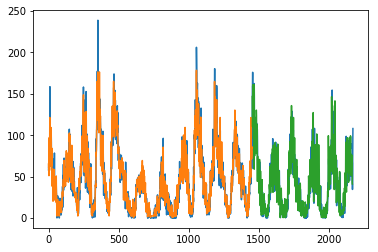

In [191]:
x = []
for i in range(0,len(testPredict)):
    x.append(i+len(trainPredict))
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredict)
plt.plot(x,testPredict)
plt.show()

In [201]:
import math
trainScore = math.sqrt(mean_squared_error(trainY[0].tolist(), trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0].tolist(), testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.48 RMSE
Test Score: 17.54 RMSE
